# This notebook provides interactive widgets to play with the imaging requirements for the SKA1 SDP

## First, do the necessary set-up (run the code block below, first)

In [2]:
""" These first few lines below import the IPython definitions and methods that we will use. 
Please Refer to ipython_api.py for the implementation """
from IPython.html.widgets import interact, interactive, fixed
from IPython.html.widgets.interaction import interact_manual
from IPython.html import widgets
from api_ipython import SkaIPythonAPI as iapi
from parameter_definitions import *
from parameter_definitions import Constants as c
from implementation import Implementation as imp

%matplotlib inline

# The lines below define the available telescopes, bands and modes that may be chosen.

available_teles = (Telescopes.SKA1_Low, Telescopes.SKA1_Low_old, Telescopes.SKA1_Mid, Telescopes.SKA1_Mid_old, 
                   Telescopes.SKA1_Sur_old, Telescopes.SKA2_Low, Telescopes.SKA2_Mid)
available_bands = (Bands.Low, 
                   Bands.Mid1, Bands.Mid2, Bands.Mid5A, Bands.Mid5B, 
                   Bands.Sur1)
available_modes     = (ImagingModes.Continuum, ImagingModes.Spectral, ImagingModes.FastImg)
available_modes_all = (ImagingModes.Continuum, ImagingModes.Spectral, ImagingModes.FastImg, ImagingModes.All)
verbose_display = False

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Using default values, we can compare telescopes side-by-side

Telescope,SKA1_Low_old,SKA1_Low_rebaselined,
Band,Low,Low,
Mode,Continuum,Continuum,
Baseline Dependent Time Avg.,False,False,
Max Baseline,100000,80000,m
Max # channels,256000,65536,
Optimal Number of Facets,1,1,
Optimal Snapshot Time,28.6,39.8,sec.
Visibility Buffer,126,25,PetaBytes
Working (cache) memory,39.3,13,TeraBytes
Image side length,4.18e+04,3.34e+04,pixels


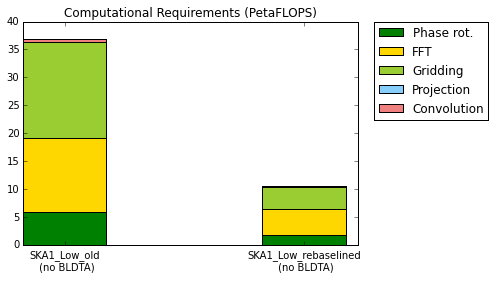

In [3]:
interact_manual(iapi.compare_telescopes_default, 
                telescope_1=available_teles, telescope_2=available_teles, band_1=available_bands,
                band_2=available_bands, mode_1=available_modes_all, mode_2=available_modes_all,
                verbose=verbose_display);

## We can also interactively play with parameters (via sliders)

### The first option is automatic updating of results as the sliders are moved. This may be sluggish

In [4]:
interact(iapi.evaluate_telescope_manual, max_baseline=(10000,200000), Nf_max = (1,256000,1), Nfacet=(1,10,1), Tsnap=(1.2,1800), 
         telescope=available_teles, band=available_bands, mode=available_modes_all, verbose=verbose_display);

Max Baseline,46969 m
Max # of channels,128000
Telescope,SKA1_Low_rebaselined
Band,Low
Mode,Continuum
Tsnap,900.6 sec
Nfacet,5


Visibility Buffer,8.69 PetaBytes
Working (cache) memory,1.84 TeraBytes
Image side length,3926 pixels
I/O Rate,55.3 TeraBytes/s
Total Compute Requirement,60.1 PetaFLOPS
-> Gridding,25.6 PetaFLOPS
-> FFT,0.0405 PetaFLOPS
-> Phase Rotation,0.111 PetaFLOPS
-> Projection,0.003 PetaFLOPS
-> Convolution,34.4 PetaFLOPS


### The second option is manual triggering of recompute events (recommended). 

#### This allows more conveniently computing elaborate (slow) optimizations and visualizations per computation, as these are only run when required
#### In this example, *Tsnap and Nfacet* are *automatically* chosen so as to minimize the value of Rflop

Max Baseline,71141 m
Max # of channels,128000
Telescope,SKA1_Low_rebaselined
Band,Low
Mode,Continuum


Optimal Number of Facets,1
Optimal Snapshot Time,39.8 sec.
Visibility Buffer,25 PetaBytes
Working (cache) memory,13 TeraBytes
Image side length,3.34e+04 pixels
I/O Rate,6.42 TeraBytes/s
Total Compute Requirement,10.6 PetaFLOPS
-> Gridding,3.89 PetaFLOPS
-> FFT,4.75 PetaFLOPS
-> Phase Rotation,0 PetaFLOPS
-> Projection,0.225 PetaFLOPS


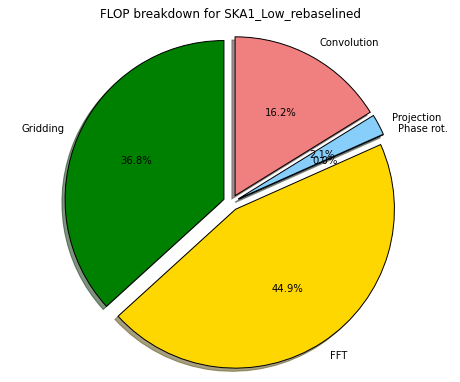

In [6]:
interact_manual(iapi.evaluate_telescope_optimized, max_baseline=(10000,200000), Nf_max = (1,256000,1), telescope=available_teles, 
         band=available_bands, mode=available_modes_all, verbose=verbose_display);

## illustrating 1D "parameter sweep" + visualization functionality.

Starting sweep of parameter amp_f_max, evaluating expression Rflop over range (1.01, 1.06) in 7 steps (i.e. 8 data points)
> 0.0% done: Evaluating Rflop for amp_f_max = 1.01
> 12.5% done: Evaluating Rflop for amp_f_max = 1.01714
> 25.0% done: Evaluating Rflop for amp_f_max = 1.02429
> 37.5% done: Evaluating Rflop for amp_f_max = 1.03143
> 50.0% done: Evaluating Rflop for amp_f_max = 1.03857
> 62.5% done: Evaluating Rflop for amp_f_max = 1.04571
> 75.0% done: Evaluating Rflop for amp_f_max = 1.05286
> 87.5% done: Evaluating Rflop for amp_f_max = 1.06
done with parameter sweep!


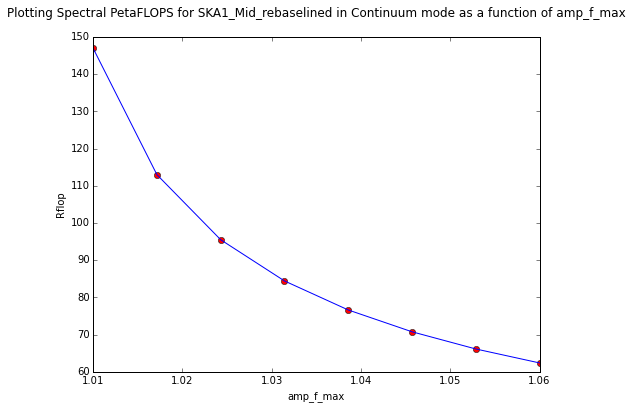

In [7]:
from IPython.display import display, HTML

expression = 'Rflop'
parameter = 'amp_f_max'
param_val_min = 1.01
param_val_max = 1.06
number_steps = 7
telescope = Telescopes.SKA1_Mid
immode = ImagingModes.Continuum
band=Bands.Mid1

display(HTML('<font color="blue">Computing the result -- this may take several (tens of) seconds.</font>'))
(param_values, results) = iapi.eval_param_sweep_1d(telescope, immode, band=band, 
                                                   expression=expression, parameter=parameter, param_val_min=param_val_min,
                                                   param_val_max=param_val_max, number_steps=number_steps, verbose=False)
header = 'Plotting Spectral PetaFLOPS for %s in %s mode as a function of %s' % (telescope, immode, parameter)
iapi.plot_line_datapoints(header, param_values, np.array(results)/c.peta, xlabel=parameter, ylabel=expression)

## illustrating 2D "parameter sweep" + visualization functionality.

In [ ]:
from IPython.display import display, HTML

telescope = Telescopes.SKA1_Low
band = Bands.Low
immode = ImagingModes.Spectral
expression = 'Rflop'
parameters = ('Na', 'Bmax')
parameter_ranges = ((100,512),(40000,80000))
number_steps = 5
verbose = False

display(HTML('<font color="blue">Computing the result -- this may take several (tens of) seconds.</font>'))
(p1_values, p2_values, results) = iapi.eval_param_sweep_2d(telescope, immode, band=band, 
                                                           expression=expression, parameters=parameters, 
                                                           params_ranges=parameter_ranges, number_steps=number_steps, 
                                                           verbose=verbose)


iapi.plot_2D_surface('PetaFLOP rate vs #Channels & Max Baseline', p1_values, p2_values, results/1e15, xlabel=parameters[0], 
                     ylabel=parameters[1], contours=np.array((0.5, 1.0)))
iapi.plot_3D_surface('PetaFLOP rate vs #Channels & Max Baseline', p1_values, p2_values, results/1e15, xlabel=parameters[0], 
                     ylabel=parameters[1], zlabel=expression, contours=np.array((0.5, 1.0)))

Evaluating expression Rflop while
sweeping parameters Na and Bmax over 2D domain [100, 512] x [40000, 80000] in 5 steps each,
for a total of 36 data evaluation points
> 0.0% done: Evaluating Rflop for (Na, Bmax) = (100.0, 40000.0)